# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендаьельных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale

In [2]:
df = pd.read_csv('../../data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовть [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


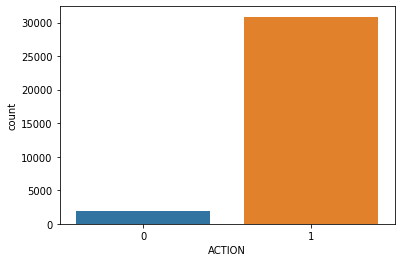

In [3]:
print(df['ACTION'].mean())
sns.countplot('ACTION', data=df)

In [4]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

In [6]:
X= df.drop(['ACTION'],axis=1)
y= df['ACTION']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [8]:
clf = KNeighborsClassifier(n_neighbors=5, p=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [9]:
y_pred = clf.predict(X_test).astype('int')

In [10]:
#отчет классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.09      0.14       614
           1       0.95      0.99      0.97     10200

    accuracy                           0.94     10814
   macro avg       0.64      0.54      0.55     10814
weighted avg       0.91      0.94      0.92     10814



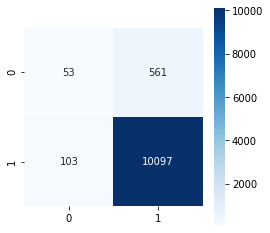

In [11]:
plt.figure(figsize=(4,4)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.5g')

Выводы:
- плотность 0 очень низкая, всего 9% предсказано верно, да и precision не высока, соответственно f1 тоже низкая. Т.к. классы не сбалансированны, то данных для 0 мало, так же мало и фич, которые помогают отнести к этому классу.
- общая accuracy высокая, но она ничего не значит, когда классы имеют такой большой дизбаланс, по сути модель в более чем 90% дает доступ пользователю, это было бы и не плохо, если бы macro avg не была такой низкой.

- precision - можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными
    - TP/(TP+FP) 
- recall(полнота) - показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм
    - TP/(TP+FN) 
- f1-score  - какой процент положительных/отриц прогнозов оказался верным
    - f1-score = 2*(Recall * Precision) / (Recall + Precision)
- accuracy — доля правильных ответов алгоритма (бесполезна в задачах с неравными классами)

&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;1  
0 TN FP  
1 FN TP
![](https://hsto.org/web/38e/9d4/892/38e9d4892d9241ea95e1f56e3ef9124c.png)

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
params = {
            "n_neighbors": [10], 
            "p": [1,2,4,6]
         }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(KNeighborsClassifier(), params, cv=cv, verbose=2,n_jobs=2,scoring='f1_macro')                    

%time search.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 219 ms, sys: 48.6 ms, total: 267 ms
Wall time: 37.8 s


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   37.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=2,
             param_grid={'n_neighbors': [10], 'p': [1, 2, 4, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=2)

In [14]:
print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

BEST: score=0.536217581675499, params={'n_neighbors': 10, 'p': 1}


BEST: score=0.536217581675499, params={'n_neighbors': 10, 'p': 1}


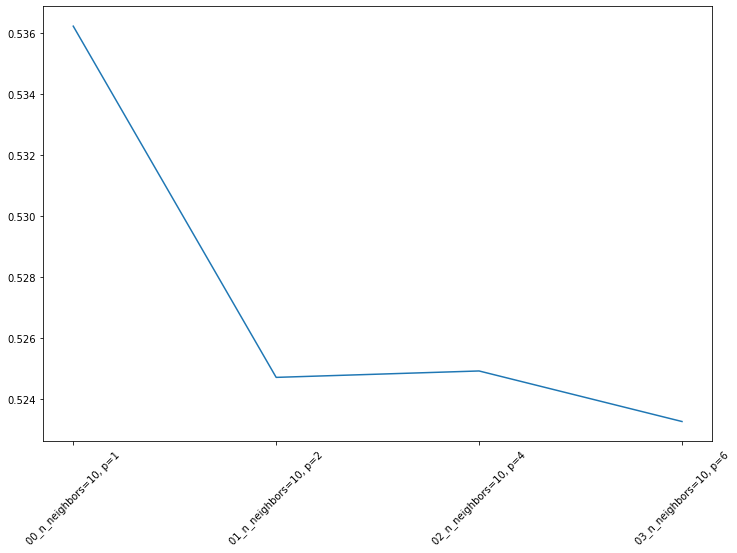

In [16]:
x_ticks = ["{:02d}_n_neighbors={}, p={}".format(i, p['n_neighbors'], p['p']) for i,p in enumerate(search.cv_results_['params'])]

plt.figure(figsize=(12,8))
plt.plot(x_ticks, search.cv_results_['mean_test_score'])
_ =plt.xticks(rotation=45)

print("BEST: score={}, params={}".format(search.best_score_, search.best_params_))

Отчет классификации стал еще хуже:

              precision    recall  f1-score   support

           0       0.30      0.04      0.07       614
           1       0.95      0.99      0.97     10200

    accuracy                           0.94     10814
   macro avg       0.62      0.52      0.52     10814
weighted avg       0.91      0.94      0.92     10814



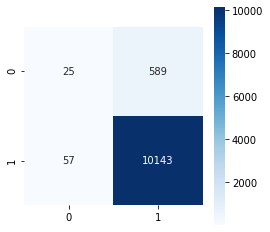

In [17]:
clf = KNeighborsClassifier(n_neighbors=search.best_params_['n_neighbors'], p=search.best_params_['p'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype('int')

print(classification_report(y_test, y_pred))

plt.figure(figsize=(4,4))
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.5g')

# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.
- Еще https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/data-transformation-learning-with-counts
-  Практический пример https://turi.com/learn/userguide/feature-engineering/count_featurizer.html
- Другие варианты энкодинга + счетчики https://kiwidamien.github.io/encoding-categorical-variables.html

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

!!! [Тут](https://kiwidamien.github.io/encoding-categorical-variables.html) указаны следующие параметры создания счетчиков. Что имеется ввиду под is_leftover?

The DRACuLa encoder isn't supported yet by category encoders. It is an interesting exercise to "roll your own". It is generally for classification problems. We are going to introduce the concept of "buckets": the most frequently occurring B levels get their own buckets. All other levels share the leftover bucket.

For binary classification, DRACuLa produces 4 columns:

    N+: the number of times the positive class has been seen in this bucket,
    N-: the number of times the negative class has been seen in this bucket,
    log(N+/N-): the log likelihood,
    is_leftover: boolean, indicating if this was one of the B levels that got its own bucket (False), or if we were in the "leftover" bucket (True)


![](https://turi.com/learn/userguide/feature-engineering/images/count_featurizer_data_split.png)

##### Счетчики. Простое разбиение данных

Чтобы избежать переобучения, тестовая выборка будет разбита на 2 части, для одной из которых будут подсчитаны counters, а другая будет просто брать эти значения. Если разбивать Train на 2 части, то в первой части (Fit) будут не все уникальные значения категорий (какие то значения будут только в Transform+Train) и для них не будут подсчитаны счетчики, что приведет к null, что в своб очередь к ухудшению качества модели.

Чтобы понимать какое соотношение уникальных заначений по категориальным фичам присутствует в выборке введу коэффициент.

In [18]:
def stratified_index(df, df_split, min_count_uniq=0):
    '''
    Коэффициент полноты уникальных значений (стратификации).
    Показывает на сколько в текущих данных присутствует все значения категорий. 1 - 100%
    '''
    def count_unique(df,min_count_uniq=0):
        #Возвращает df с уникальными значениями и их количеством
        grp_cnt =df.groupby([col])[col].count()
        df_fc = pd.DataFrame(dict(value=grp_cnt.index, count=grp_cnt.values))
        df_fc = df_fc[df_fc['count']>min_count_uniq]
        return df_fc
    
    df_iu=pd.DataFrame()
    for col in df.columns:  
        uniq_count = count_unique(df.copy(),min_count_uniq).shape[0]
        split_uniq_count = count_unique(df_split.copy(),min_count_uniq).shape[0]
        if (0==split_uniq_count or 0==uniq_count):
            index_unique=0
        else:
            index_unique = split_uniq_count/uniq_count
        values = [index_unique, '{}/{}'.format(split_uniq_count,uniq_count)]
        df_iu.at[0, col] = '{:.4f}'.format(index_unique)
        df_iu.at[1, col] = '{}/{}'.format(split_uniq_count,uniq_count)
        df_iu.at[2, col] = '{}'.format(uniq_count)
    return df_iu

In [19]:
def CountAndSuccCalc(df, df_counts, col_name, method=1):
    '''
    Подсчет новых признаков - счетчиков
    '''     
    print()
    if (1==method): #Метод из задания
        c = df[col_name].apply(lambda value: df_counts[value].sum()) #сумма встречающихся значений и 0 и 1, по сути количество категории
        try:
            s = df[col_name].apply(lambda value: df_counts[value].iloc[1]) #количество значения категории при у=1
        except:
            s = 0
        f = (s+1)/(c+2)
        out = [c,s,f]
        #out = [c.values[0],s,f]
    if (2==method): #Метод из интернета
        c = df[col_name].apply(lambda value: df_counts[value].sum()) #сумма встречающихся значений 0 и 1, по сути количество категории
        s = df[col_name].apply(lambda value: df_counts[value].iloc[1]) #количество значения категории при у=1
        n = c-s #количество значения категории при у=0
        f = np.log((s+1)/(n+1)) 
        #??? По умолчанию все элементы с количеством меньше 10 собираются в одном контейнере, называемом «мусорное ведро».
        #out = [c,s,n,f]
        out = [c.values[0],s,n,f]
    return out

In [20]:
def CountAndSuccMainSimple (df, train_part_by_target_size=0.7, y_name = 'ACTION', method=1):
    '''
    Формирование новых признаков - счетчиков.
    Тренеровочная выборка будет разбита на 2 части, для первой будут подсчитаны счетчики, воторая часть будет 
    брать уже готовые счетчики первой части.
    
    train_part_by_target_size - пропорция от общего числа тренеровочной выборки, у которой counts и successes будут 
                    строится по целевому признаку, остальные части на основании train_part_by_target_size.
                    Если == 1, то вторая часть тренеровочной выборки буде считаться тоже по целевому признаку
    '''
    
    #Создаю новые признаки и наполняю их NaN, далее буду считать точные значения
    col_names = df.drop([y_name],axis=1).columns
    for col_name in col_names:
        if (1==method):
            df[col_name+'_count'], df[col_name+'_successes'], df[col_name+'_flattened'] = list(3*[np.NaN])
        if (2==method):
            df[col_name+'_count'], df[col_name+'_successes'], df[col_name+'_not_successes'], df[col_name+'_flattened'] = list(4*[np.NaN])
 
    X = df.drop([y_name],axis=1)
    y = df[y_name]
    
    X_train_orig, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)
    
    X_train_spliter = int(X_train_orig.shape[0]*train_part_by_target_size)# Индекс-разделитель тренеровочной выборки на 2 части
    X_train_by_target = X_train_orig.iloc[:X_train_spliter] # Новые признаки-счетчики для этой части будут строиться на основе целевого
    X_train = X_train_orig.iloc[X_train_spliter:] # Новые признаки-счетчики для этой части будут строиться на основе X_train_by_target
    
    ###Коэффициент стратификации
    strat_index = stratified_index(X_train_orig[col_names],X_train_by_target[col_names],0)  
    
    #Счетчики для первой части тренеровочной выборки
    for col_name in col_names:
                    #формирую новую выборку с целевой переменной,на основе индексов train_test_split, чтобы произвести рассчеты    
        df_counts = pd.DataFrame(index=X_train_by_target.index, data=df).groupby([y_name,col_name])[col_name].count().unstack().fillna(0)# группирую данные в таблицу, где именования столбцов это уникальные значения col_name, а в строках количество повторений при у = [0,1] 
        if (1==method):
            X_train_by_target[col_name+'_count'], X_train_by_target[col_name+'_successes'], X_train_by_target[col_name+'_flattened'] = CountAndSuccCalc(X_train_by_target,df_counts,col_name)  
        if (2==method):
            X_train_by_target[col_name+'_count'], X_train_by_target[col_name+'_successes'], X_train_by_target[col_name+'_not_successes'], X_train_by_target[col_name+'_flattened'] = CountAndSuccCalc(X_train_by_target,df_counts,col_name, 2)  
  
    #Счетчики на основе первой части тренеровочной выборки
    for col_name in col_names:
        if X_train.shape[0] > 0: #Если есть втроая часть тренеровочной выборки (train_part_by_target_size<1)
            for value in X_train[col_name].unique():#Счетчики для второй части тренеровочной выборки на основе первой части     
                if value in X_train_by_target[col_name].values: # Если в первой части тренеровочной выборки существует значение из второй части тренеровочной выборки
                    if (1==method):
                        X_train.loc[X_train[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']][:1].values[0]                
                    if (2==method):
                        X_train.loc[X_train[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']][:1].values[0]                
        
        for value in X_test[col_name].unique(): #Счетчики для тестовой выборки на основе первой части тренеровочной выборки
            if value in X_train_by_target[col_name].values: # Если в первой части тренеровочной выборки существует значение из тестовой выборки
                if (1==method):
                    X_test.loc[X_test[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']][:1].values[0]                
                if (2==method):
                    X_test.loc[X_test[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']][:1].values[0]                
    #print('------------ train_part_one:\n\n{}'.format(X_train_by_target))
    #print('\n------------ train_part_two:\n\n{}'.format(X_train))
    #print('\n------------ test:\n\n{}'.format(X_test))
    X_train = pd.concat([X_train_by_target,X_train])
    return X_train[np.setdiff1d(X_train.columns,col_names)], X_test[np.setdiff1d(X_test.columns,col_names)], y_train, y_test, strat_index

In [999]:
%%time
X_train_orig_s,\
X_test_orig_s,\
y_train_orig_s,\
y_test_orig_s,\
strat_index_simple = CountAndSuccMainSimple(df.copy(), 0.7, method=1)

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


CPU times: user 1min 43s, sys: 144 ms, total: 1min 43s
Wall time: 1min 43s


In [483]:
X = df.drop(['ACTION'],axis=1)
y = df['ACTION']

In [620]:
#На исходных индекс должен равняться 1
stratified_index(X.copy(),X.copy(),0)

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,7518/7518,4243/4243,128/128,177/177,449/449,343/343,2358/2358,67/67,343/343
2,7518,4243,128,177,449,343,2358,67,343


In [621]:
#Результат при не стратифицированном разбиении
strat_index_simple

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,0.8198,0.9133,0.9919,0.9822,0.9749,0.9755,0.8862,1.0000,0.9755
1,5114/6238,3560/3898,122/123,166/169,427/438,319/327,1869/2109,65/65,319/327
2,6238,3898,123,169,438,327,2109,65,327


In [622]:
#средний коэффициент содержания всех уникальных значений исходной выборки в разделенной
strat_index_simple.loc[0].astype('float').mean()

0.9465888888888888

Как видим не 100% уникальных категорий попадает в трейн, в среднем 95% (что в принципе то и не так мало)

In [623]:
print('X_train, shape: {}, null:{}'.format(X_train.shape, X_train_orig_s.isnull().sum().sum()))

X_train, shape: (22938, 27), null:6069


In [624]:
print('X_test, shape: {}, null:{}'.format(X_test.shape, X_test_orig_s.isnull().sum().sum()))

X_test, shape: (9831, 27), null:9072


При подсчете счетчиков таким методом, неизбежно появляются null, т.к. не все значения категорий есть в трейне.  
Попробую избежать этого...

###### Счетчики. Равномерное разбиение по группам

Суть идеи стратифицированного разбиения:  
    См. картинку ниже.  
- После разбиения данных на Train, Validation нужно разбить Train на 2 части в заданной пропорции, для первой части(Fit) подсчитать counters, для вотрой(Transform+Train) просто взять counters из первой части, все это чтобы  не переобучиться. Но если разбить просто так Train, то в части Transform+Train могут будут значения категориальных фич, которых нет в Fit, что снизит качество.  
    
    Идея в том, чтобы часть Fit содержала в себе все возможные уникальные значения из Train, чтобы для всех были подсчитаны счетчики.         

![](https://turi.com/learn/userguide/feature-engineering/images/count_featurizer_data_split.png)

[Отсюда ничего не смог применить, т.к. нужно чтобы все значения были как минимум в 2х экземплярах (см. пример ниже), а у нас не так, да и все категориальные фичи все равно не возьмет](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)

In [21]:
def CountAndSuccMainStratified (df, train_part_by_target_size=0.7, y_name = 'ACTION', method=1):
    '''
    ###Страшная вещь! Сам в шоке! Но задуманную задачу выполняет, оптимизировать пока не стал. Ниже есть маленький пример.
        
    train_part_by_target_size - пропорция от общего числа тренеровочной выборки, у которой counts и successes будут 
                    строится по целевому признаку, остальные части на основании train_part_by_target_size.
                    Если == 1, то вторая часть тренеровочной выборки буде считаться тоже по целевому признаку
    '''
    
    #Создаю новые признаки и наполняю их NaN, далее буду считать точные значения
    col_names = df.drop([y_name],axis=1).columns
    for col_name in col_names:
        if (1==method):
            df[col_name+'_count'], df[col_name+'_successes'], df[col_name+'_flattened'] = list(3*[np.NaN])
        if (2==method):
            df[col_name+'_count'], df[col_name+'_successes'], df[col_name+'_not_successes'], df[col_name+'_flattened'] = list(4*[np.NaN])
 
    X = df.drop([y_name],axis=1)
    y = df[y_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)    
    X_train_new = pd.DataFrame()
    #Тренеровочную выборку еще разобью на 2 части, для одной подсчитаю counters, для другой возьму значения на основе первой
    for col_name in col_names:
        #Обратно добавляю целевой признак, чтобы сделать группировку
        df_tmp = X_train.copy()
        df_tmp[y_name] = y_train
        df_tmp_g1 = pd.DataFrame()
        df_tmp_g2 = pd.DataFrame()
        #По каждой категории беру новую выборку частью от X_train равномерно разбитую(stratify) по уникальным значениям этой категории (col_name)
        if (train_part_by_target_size <1):
            #X_col_train, X_col_train2, y_col_train, y_col_train2 = train_test_split(X_train[col_name], y_train, random_state=42, test_size=1-train_part_by_target_size, stratify=X_train[col_name])
            df_tmp_g1 = df_tmp[[col_name,y_name]].groupby(col_name).filter(lambda x: len(x) > 1) #элементы где не менее 2х значений в уникальной группе
            df_tmp_g2 = df_tmp[[col_name,y_name]].groupby(col_name).filter(lambda x: len(x) <= 1)#элементы где менее 2х значений в уникальной группе, по сути одиночные значения
            # Ту часть X_train, где для уникального значения категории есть минимум 2 записи, разбиваю на 2 части(в заданных пропорциях) равномерно (stratify)
            X_col_train, X_col_train2, y_col_train, y_col_train2 = train_test_split(df_tmp_g1[col_name], df_tmp_g1[y_name], random_state=42, test_size=1-train_part_by_target_size, stratify=df_tmp_g1[col_name])      
        else:
            X_col_train, X_col_train2, y_col_train, y_col_train2 = X_train, pd.DataFrame(), y_train, pd.DataFrame()
        
    ###Счетчики для первой части тренеровочной выборки
        #Обратно добавляю целевой признак, чтобы сделать группировку
        X_train_by_target = pd.concat([X_col_train, y_col_train], axis=1, sort=False) 
        df_counts = X_train_by_target.groupby([y_name,col_name])[col_name].count().unstack().fillna(0)# группирую данные в таблицу, где именования столбцов это уникальные значения col_name, а в строках количество повторений при у = [0,1] 
        if (1==method):
            X_train_by_target[col_name+'_count'], X_train_by_target[col_name+'_successes'], X_train_by_target[col_name+'_flattened'] = CountAndSuccCalc(X_train_by_target,df_counts,col_name)  
        if (2==method):
            X_train_by_target[col_name+'_count'], X_train_by_target[col_name+'_successes'], X_train_by_target[col_name+'_not_successes'], X_train_by_target[col_name+'_flattened'] = CountAndSuccCalc(X_train_by_target,df_counts,col_name, 2)  
        
    ###Отдельно выполняю подчет счетчиков для значений которые встречаются только 1 раз в датасете
        #Обратно добавляю целевой признак, чтобы сделать группировку      
        if (train_part_by_target_size <1):
            df_counts = df_tmp_g2.groupby([y_name,col_name])[col_name].count().unstack().fillna(0)# группирую данные в таблицу, где именования столбцов это уникальные значения col_name, а в строках количество повторений при у = [0,1] 
            if (1==method):
                df_tmp_g2[col_name+'_count'], df_tmp_g2[col_name+'_successes'], df_tmp_g2[col_name+'_flattened'] = CountAndSuccCalc(df_tmp_g2.copy(),df_counts,col_name)  
            if (2==method):
                df_tmp_g2[col_name+'_count'], df_tmp_g2[col_name+'_successes'], df_tmp_g2[col_name+'_not_successes'], df_tmp_g2[col_name+'_flattened'] = CountAndSuccCalc(df_tmp_g2,df_counts,col_name, 2)          
        
    ###Счетчики для второй части на основе первой части тренеровочной выборки
        if (train_part_by_target_size <1): #Если есть втроая часть тренеровочной выборки
            X_col_train2 = pd.concat([X_col_train2], axis=1, sort=False)
            X_col_train2[y_name] = y_col_train2
            #Создам необходимые столбцы для счетчиков
            if (1==method):
                X_col_train2[col_name+'_count'], X_col_train2[col_name+'_successes'], X_col_train2[col_name+'_flattened'] = list(3*[np.NaN])
            if (2==method):
                X_col_train2[col_name+'_count'], X_col_train2[col_name+'_successes'], X_col_train2[col_name+'_not_successes'], X_col_train2[col_name+'_flattened'] = list(4*[np.NaN])
            for value in X_col_train2[col_name].unique():#Счетчики для второй части тренеровочной выборки на основе первой части     
                if value in X_train_by_target[col_name].values: # Если в первой части тренеровочной выборки существует значение из второй части тренеровочной выборки
                    if (1==method):
                        X_col_train2.loc[X_col_train2[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']][:1].values[0]                
                    if (2==method):
                        X_col_train2.loc[X_col_train2[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']][:1].values[0]                
   ###Объединяю все части тренеровочной выборки в единую       
        X_train_by_target.drop(y_name,axis=1,inplace=True)
        if (train_part_by_target_size <1):
            X_col_train2.drop(y_name,axis=1,inplace=True)
            df_tmp_g2.drop(y_name,axis=1,inplace=True)
            X_train_new = pd.concat([X_train_new,pd.concat([X_train_by_target,X_col_train2,df_tmp_g2])], axis=1, sort=False)
        else:
            X_train_new = X_train_by_target
    ###Счетчики для тестовой выборки на основе тренеровочной выборки
        for value in X_test[col_name].unique(): #Счетчики для тестовой выборки на основе первой части тренеровочной выборки
            if value in X_train_by_target[col_name].values: # Если в первой части тренеровочной выборки существует значение из тестовой выборки
                if (1==method):
                    X_test.loc[X_test[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_flattened']][:1].values[0]                
                if (2==method):
                    X_test.loc[X_test[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']] = X_train_by_target.loc[X_train_by_target[col_name] == value,[col_name+'_count',col_name+'_successes',col_name+'_not_successes',col_name+'_flattened']][:1].values[0]                

    #return X_train_new[np.setdiff1d(X_train.columns,col_names)], X_test[np.setdiff1d(X_test.columns,col_names)], y_train, y_test
    ###Коэффициент стратификации
    strat_index = stratified_index(X_train[col_names],X_train_new[col_names],0)
    return X_train_new[np.setdiff1d(X_train_new.columns,col_names)],X_test[np.setdiff1d(X_test.columns,col_names)],y_train, y_test, strat_index

----- Пример работы - проверка -------

In [586]:
df_tmp1=pd.DataFrame({'k1':[1,1,1,1,1,3,2,2,2],'k2':[4,4,4,4,4,4,5,6,6],'ACTION':[1,0,1,1,1,0,0,0,0]})
df_tmp1

,k1,k2,ACTION
0,1,4,1
1,1,4,0
2,1,4,1
3,1,4,1
4,1,4,1
5,3,4,0
6,2,5,0
7,2,6,0
8,2,6,0


Значение 3 для k1 и k2 имеет всего 1 значение, использовать Stratified из sklearn.model_selection не получиться, т.к. нужно минимум 2. Функция сначала выбирает все значения где уникальных значений минимум 2, стратифицирует каждый столбец, считает счетчики, затем отдельно считает счетчики для единичных значений типа 3 и все это объединяет в Fit (см. рисунок выше)

In [997]:
Train, Validation, y_train_ex, y_val_ex, strat_index_tmp  = CountAndSuccMainStratified(df_tmp1.copy(), 0.7, method=1)

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Строки [0,1,2,3] = Fit  
Строки [4,5] = Transform+Train  
Для [0,1,2] были подсчитаны счетчики без [4,5] и [3]  
Для [3] были подсчитаны счетчики отдельно для одного значения  


In [602]:
Train

,k1_count,k1_flattened,k1_successes,k2_count,k2_flattened,k2_successes
0,2.0,0.750000,2.0,2.0,0.500000,1.0
2,2.0,0.750000,2.0,2.0,0.500000,1.0
3,2.0,0.750000,2.0,2.0,0.500000,1.0
5,1.0,0.333333,0.0,2.0,0.500000,1.0
6,1.0,0.333333,0.0,1.0,0.333333,0.0
8,1.0,0.333333,0.0,1.0,0.333333,0.0


In [603]:
Validation

,k1_count,k1_flattened,k1_successes,k2_count,k2_flattened,k2_successes
4,2.0,0.750000,2.0,2.0,0.5,1.0
7,1.0,0.333333,0.0,NaN,NaN,NaN
1,2.0,0.750000,2.0,2.0,0.5,1.0


null в тесте так и остались, но в "Fit" полный набор уникальных значений "Train"

In [604]:
strat_index_tmp 

,k1,k2
0,1.0000,1.0000
1,3/3,3/3
2,3,3


----- Закончен. Пример работы - проверка -------

Выполняю разделение на стратифицированный трейн и тест для наших данных с использованием описанной выше функции

In [998]:
%%time
X_train_orig,\
X_test_orig,\
y_train_orig,\
y_test_orig,\
strat_index = CountAndSuccMainStratified(df.copy(), 0.7, method=1)

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


CPU times: user 1min 55s, sys: 148 ms, total: 1min 55s
Wall time: 1min 55s


In [606]:
strat_index

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,6238/6238,3898/3898,123/123,169/169,438/438,327/327,2109/2109,65/65,327/327
2,6238,3898,123,169,438,327,2109,65,327


Т.о. в трейне удалось избежать null, они остались только в тесте.

In [607]:
print('X_train_orig, shape: {}, null:{}'.format(X_train_orig.shape, X_train_orig.isnull().sum().sum()))

X_train_orig, shape: (22938, 27), null:0


In [608]:
print('X_test_orig, shape: {}, null:{}'.format(X_test_orig.shape, X_test_orig.isnull().sum().sum()))

X_test_orig, shape: (9831, 27), null:12399


In [610]:
X_test_orig.isnull().sum()

MGR_ID_count                   961
MGR_ID_flattened               961
MGR_ID_successes               961
RESOURCE_count                2425
RESOURCE_flattened            2425
RESOURCE_successes            2425
ROLE_CODE_count                 37
ROLE_CODE_flattened             37
ROLE_CODE_successes             37
ROLE_DEPTNAME_count             26
ROLE_DEPTNAME_flattened         26
ROLE_DEPTNAME_successes         26
ROLE_FAMILY_DESC_count         611
ROLE_FAMILY_DESC_flattened     611
ROLE_FAMILY_DESC_successes     611
ROLE_FAMILY_count               11
ROLE_FAMILY_flattened           11
ROLE_FAMILY_successes           11
ROLE_ROLLUP_1_count              8
ROLE_ROLLUP_1_flattened          8
ROLE_ROLLUP_1_successes          8
ROLE_ROLLUP_2_count             17
ROLE_ROLLUP_2_flattened         17
ROLE_ROLLUP_2_successes         17
ROLE_TITLE_count                37
ROLE_TITLE_flattened            37
ROLE_TITLE_successes            37
dtype: int64

#####  Перебор гиперпараметров.

Чем заменить null?
- Заменять средним значением мне кажется не правильным, потому что большое стандартное отклонение, медиана выглядит лучше, но тоже мне кажется не корректным решением.  
    Удалять - слишком много данных теряется.  
    Заменять нулями тоже так себе решение.  

В общем возможно доберусь в будущем и поэксперементирую над другими методами, но это уже другая история...


In [22]:
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, RobustScaler

In [23]:
from tqdm import tqdm

In [24]:
import time

In [25]:
def fillna(tr, tst, method):
    if 'mean_train' == method:
        tr = tr.fillna(tr.mean())
        tst =  tst.fillna(tr.mean())
    elif 'median_train' == method:
        tr = tr.fillna(tr.median())
        tst =  tst.fillna(tr.median())
    elif 'mode_train' == method:
        tr = tr.fillna(tr.mode().iloc[0])
        tst =  tst.fillna(tr.mode().iloc[0])
    elif 'zero' == method:
        tr = tr.fillna(tr.fillna(0))
        tst =  tst.fillna(tst.fillna(0))
    return tr, tst

In [26]:
def scale(tr, tst, method):
    if 'StandardScaler' == method:
        scaler = StandardScaler()
        tr = scaler.fit_transform(tr)
        tst = scaler.transform(tst)
    elif 'MinMaxScaler' == method:
        scaler = MinMaxScaler()
        tr = scaler.fit_transform(tr)
        tst = scaler.transform(tst)
    elif 'RobustScaler' == method:
        scaler = RobustScaler()
        tr = scaler.fit_transform(tr)
        tst = scaler.transform(tst)
    elif 'None'  == method:
        pass
    return tr, tst

In [39]:
#methods = ['mean_train','mean_test','median_train','median_test','mode_train','mode_test','zero']
methods = ['mean_train','median_train','mode_train','zero']
scalers = ['StandardScaler','MinMaxScaler','RobustScaler','None']

def pipe_best_counters(size,formula,reports_df,Xtr,Xtst,ytr,ytst,methods=methods,scalers=scalers):
    for method in methods:
        Xtr_mod, Xtst_mod = fillna(Xtr.copy(), Xtst.copy(), method)
        for scaler in scalers:
            Xtr_mod, Xtst_mod = scale(Xtr_mod, Xtst_mod, scaler)
            params = {
                "n_neighbors": [3,4,5],#7,10], 
                "p": [1,2]
            }
            search = GridSearchCV(KNeighborsClassifier(), params, n_jobs=2,
                      cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),scoring='f1_macro', verbose=0)
            search.fit(Xtr_mod,ytr)
            y_pred_pbc = search.predict(Xtst_mod)
            y_pred_pbc_train = search.predict(Xtr_mod)
            report = classification_report(ytst, y_pred_pbc)
            report_train = classification_report(ytr, y_pred_pbc_train)
            macro_avg = report.split('\n')[6].split('     ')[3].strip()
            macro_avg_train = report_train.split('\n')[6].split('     ')[3].strip()
            reports_df = reports_df.append({'Accuracy':search.best_score_,'Macro_avg_test':macro_avg,'Macro_avg_train':macro_avg_train\
                                            ,'Size':size,'Formula':formula,'Method':method,'Scaler':scaler\
                                            ,'Search.best_params_':search.best_params_,'Reports':report},ignore_index=True)
            print(reports_df.tail(1).drop(['Reports'],axis=1).T)
            print(report)
            print('\n\n')
    #print('sleep')
    #time.sleep(300) # Сон, чтобы проц не перегрелся
    return reports_df

In [28]:
reports_df = pd.DataFrame({'Accuracy':[],'Macro_avg_test':[],'Macro_avg_train':[],'Size':[],'Formula':[],'Method':[]\
                           ,'Scaler':[],'Search.best_params_':[],'Reports':[]})

In [ ]:
sizes = [0.4,0.5,0.6,0.7,0.8,1]
formulas=['Simple','Stratified']
start=False

if start:
    for size in tqdm(sizes):
        for formula in formulas:
            if 'Simple'==formula:
                X_trainCaS, X_testCaS, y_trainCaS, y_testCaS, strat_index_iter = CountAndSuccMainSimple(df.copy(), size, method=1)
                reports_df = pipe_best_counters(size=size,formula=formula,reports_df=reports_df,Xtr=X_trainCaS,Xtst=X_testCaS,ytr=y_trainCaS,ytst=y_testCaS)        
            if 'Stratified'==formula:
                X_trainCaS, X_testCaS, y_trainCaS, y_testCaS, strat_index_iter = CountAndSuccMainStratified(df.copy(), size, method=1)
                reports_df = pipe_best_counters(size=size,formula=formula,reports_df=reports_df,Xtr=X_trainCaS,Xtst=X_testCaS,ytr=y_trainCaS,ytst=y_testCaS)
    
    reports_df[reports_df['Formula']=='Stratified'].sort_values(by='Macro_avg_train',ascending=False)   

In [990]:
#reports_df.sort_values(by='Macro_avg_test',ascending=False).to_csv(r'reports_df_1306.xlsx', index = True, header=True)

In [1055]:
reports_df

,Accuracy,Macro_avg_test,Macro_avg_train,Size,Formula,Method,Scaler,Search.best_params_,Reports
0,0.731728,0.69,0.84,0.4,Simple,mean_train,StandardScaler,"{n_neighbors: 4, p: 2}",precision recall f1-score ...
1,0.732400,0.70,0.84,0.4,Simple,mean_train,MinMaxScaler,"{n_neighbors: 4, p: 2}",precision recall f1-score ...
2,0.721699,0.69,0.83,0.4,Simple,mean_train,RobustScaler,"{n_neighbors: 4, p: 2}",precision recall f1-score ...
3,0.721699,0.69,0.83,0.4,Simple,mean_train,None,"{n_neighbors: 4, p: 2}",precision recall f1-score ...
4,0.731076,0.69,0.84,0.4,Simple,median_train,StandardScaler,"{n_neighbors: 4, p: 2}",precision recall f1-score ...
...,...,...,...,...,...,...,...,...,...
171,0.793417,0.69,0.88,1.0,Simple,mode_train,None,"{n_neighbors: 4, p: 2}",precision recall f1-score ...
172,0.799077,0.54,0.88,1.0,Simple,zero,StandardScaler,"{n_neighbors: 4, p: 2}",precision recall f1-score ...
173,0.798539,0.54,0.88,1.0,Simple,zero,MinMaxScaler,"{n_neighbors: 4, p: 2}",precision recall f1-score ...
174,0.793417,0.55,0.88,1.0,Simple,zero,RobustScaler,"{n_neighbors: 4, p: 2}",precision recall f1-score ...


In [1054]:
reports_df.iloc[176:]

,Accuracy,Macro_avg_test,Macro_avg_train,Size,Formula,Method,Scaler,Search.best_params_,Reports


  0%|          | 0/6 [00:00<?, ?it/s]

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


                                                0
Accuracy                     [0.7317275097657719]
Macro_avg_test                             [0.69]
Macro_avg_train                            [0.84]
Size                                        [0.4]
Formula                                  [Simple]
Method                               [mean_train]
Scaler                           [StandardScaler]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.47      0.37      0.42       569
           1       0.96      0.97      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.71      0.67      0.69      9831
weighted avg       0.93      0.94      0.94      9831




                                                1
Accuracy                      [0.732399922325741]
Macro_avg_test                             [0.70]
Macro_avg_train                            [0.84]
Size                

                                               11
Accuracy                     [0.7128774550246367]
Macro_avg_test                             [0.70]
Macro_avg_train                            [0.83]
Size                                        [0.4]
Formula                                  [Simple]
Method                               [mode_train]
Scaler                                     [None]
Search.best_params_  [{'n_neighbors': 4, 'p': 1}]
              precision    recall  f1-score   support

           0       0.52      0.38      0.44       569
           1       0.96      0.98      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.74      0.68      0.70      9831
weighted avg       0.94      0.94      0.94      9831




                                               12
Accuracy                     [0.7084623568791398]
Macro_avg_test                             [0.71]
Macro_avg_train                            [0.83]
Size                

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


                                               16
Accuracy                     [0.5065723866321937]
Macro_avg_test                             [0.50]
Macro_avg_train                            [0.61]
Size                                        [0.4]
Formula                              [Stratified]
Method                               [mean_train]
Scaler                           [StandardScaler]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.09      0.03      0.05       569
           1       0.94      0.98      0.96      9262

    accuracy                           0.92      9831
   macro avg       0.51      0.51      0.50      9831
weighted avg       0.89      0.92      0.91      9831




                                               17
Accuracy                     [0.5007234955583443]
Macro_avg_test                             [0.49]
Macro_avg_train                            [0.61]
Size                

                                               27
Accuracy                     [0.5048333100580908]
Macro_avg_test                             [0.50]
Macro_avg_train                            [0.61]
Size                                        [0.4]
Formula                              [Stratified]
Method                               [mode_train]
Scaler                                     [None]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.08      0.03      0.04       569
           1       0.94      0.98      0.96      9262

    accuracy                           0.93      9831
   macro avg       0.51      0.50      0.50      9831
weighted avg       0.89      0.93      0.91      9831




                                               28
Accuracy                     [0.5065723866321937]
Macro_avg_test                             [0.50]
Macro_avg_train                            [0.61]
Size                

 17%|█▋        | 1/6 [45:43<3:48:37, 2743.42s/it]

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


                                               32
Accuracy                     [0.7456857894007167]
Macro_avg_test                             [0.69]
Macro_avg_train                            [0.85]
Size                                        [0.5]
Formula                                  [Simple]
Method                               [mean_train]
Scaler                           [StandardScaler]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.45      0.37      0.41       569
           1       0.96      0.97      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.71      0.67      0.69      9831
weighted avg       0.93      0.94      0.93      9831




                                               33
Accuracy                       [0.74636656578986]
Macro_avg_test                             [0.69]
Macro_avg_train                            [0.85]
Size                

                                               43
Accuracy                     [0.7258353053968315]
Macro_avg_test                             [0.70]
Macro_avg_train                            [0.84]
Size                                        [0.5]
Formula                                  [Simple]
Method                               [mode_train]
Scaler                                     [None]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.50      0.36      0.42       569
           1       0.96      0.98      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.73      0.67      0.70      9831
weighted avg       0.93      0.94      0.94      9831




                                               44
Accuracy                     [0.7204894427114358]
Macro_avg_test                             [0.70]
Macro_avg_train                            [0.83]
Size                

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


                                               48
Accuracy                     [0.5011855309818558]
Macro_avg_test                             [0.49]
Macro_avg_train                            [0.61]
Size                                        [0.5]
Formula                              [Stratified]
Method                               [mean_train]
Scaler                           [StandardScaler]
Search.best_params_  [{'n_neighbors': 4, 'p': 1}]
              precision    recall  f1-score   support

           0       0.04      0.01      0.02       569
           1       0.94      0.98      0.96      9262

    accuracy                           0.92      9831
   macro avg       0.49      0.50      0.49      9831
weighted avg       0.89      0.92      0.91      9831




                                               49
Accuracy                     [0.5033571010013475]
Macro_avg_test                             [0.49]
Macro_avg_train                            [0.62]
Size                

                                               59
Accuracy                     [0.5031049822877146]
Macro_avg_test                             [0.50]
Macro_avg_train                            [0.61]
Size                                        [0.5]
Formula                              [Stratified]
Method                               [mode_train]
Scaler                                     [None]
Search.best_params_  [{'n_neighbors': 4, 'p': 1}]
              precision    recall  f1-score   support

           0       0.07      0.03      0.04       569
           1       0.94      0.98      0.96      9262

    accuracy                           0.92      9831
   macro avg       0.51      0.50      0.50      9831
weighted avg       0.89      0.92      0.91      9831




                                               60
Accuracy                     [0.5011855309818558]
Macro_avg_test                             [0.49]
Macro_avg_train                            [0.61]
Size                

 33%|███▎      | 2/6 [1:31:00<3:02:22, 2735.57s/it]

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


                                               64
Accuracy                     [0.7604163509949621]
Macro_avg_test                             [0.69]
Macro_avg_train                            [0.86]
Size                                        [0.6]
Formula                                  [Simple]
Method                               [mean_train]
Scaler                           [StandardScaler]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.46      0.36      0.41       569
           1       0.96      0.97      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.71      0.67      0.69      9831
weighted avg       0.93      0.94      0.93      9831




                                               65
Accuracy                     [0.7582775577379331]
Macro_avg_test                             [0.69]
Macro_avg_train                            [0.86]
Size                

                                               75
Accuracy                     [0.7333248701023098]
Macro_avg_test                             [0.70]
Macro_avg_train                            [0.84]
Size                                        [0.6]
Formula                                  [Simple]
Method                               [mode_train]
Scaler                                     [None]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.53      0.37      0.43       569
           1       0.96      0.98      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.75      0.67      0.70      9831
weighted avg       0.94      0.94      0.94      9831




                                               76
Accuracy                     [0.7307930678033051]
Macro_avg_test                             [0.69]
Macro_avg_train                            [0.84]
Size                

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


                                               80
Accuracy                     [0.5018526515682958]
Macro_avg_test                             [0.50]
Macro_avg_train                            [0.61]
Size                                        [0.6]
Formula                              [Stratified]
Method                               [mean_train]
Scaler                           [StandardScaler]
Search.best_params_  [{'n_neighbors': 4, 'p': 1}]
              precision    recall  f1-score   support

           0       0.08      0.02      0.04       569
           1       0.94      0.98      0.96      9262

    accuracy                           0.93      9831
   macro avg       0.51      0.50      0.50      9831
weighted avg       0.89      0.93      0.91      9831




                                               81
Accuracy                     [0.5053510262900941]
Macro_avg_test                             [0.50]
Macro_avg_train                            [0.61]
Size                

                                               91
Accuracy                     [0.5041454335724854]
Macro_avg_test                             [0.51]
Macro_avg_train                            [0.61]
Size                                        [0.6]
Formula                              [Stratified]
Method                               [mode_train]
Scaler                                     [None]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.09      0.04      0.05       569
           1       0.94      0.98      0.96      9262

    accuracy                           0.92      9831
   macro avg       0.52      0.51      0.51      9831
weighted avg       0.89      0.92      0.91      9831




                                               92
Accuracy                     [0.5018526515682958]
Macro_avg_test                             [0.50]
Macro_avg_train                            [0.61]
Size                

 50%|█████     | 3/6 [2:16:14<2:16:27, 2729.02s/it]

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


                                               96
Accuracy                     [0.7750366955430502]
Macro_avg_test                             [0.68]
Macro_avg_train                            [0.86]
Size                                        [0.7]
Formula                                  [Simple]
Method                               [mean_train]
Scaler                           [StandardScaler]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.45      0.35      0.39       569
           1       0.96      0.97      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.71      0.66      0.68      9831
weighted avg       0.93      0.94      0.93      9831




                                               97
Accuracy                     [0.7747605319676123]
Macro_avg_test                             [0.68]
Macro_avg_train                            [0.86]
Size                

                                              107
Accuracy                      [0.755112044811575]
Macro_avg_test                             [0.70]
Macro_avg_train                            [0.85]
Size                                        [0.7]
Formula                                  [Simple]
Method                               [mode_train]
Scaler                                     [None]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.54      0.36      0.43       569
           1       0.96      0.98      0.97      9262

    accuracy                           0.95      9831
   macro avg       0.75      0.67      0.70      9831
weighted avg       0.94      0.95      0.94      9831




                                              108
Accuracy                     [0.7471364256370503]
Macro_avg_test                             [0.69]
Macro_avg_train                            [0.85]
Size                

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


                                              112
Accuracy                     [0.5047726491685841]
Macro_avg_test                             [0.50]
Macro_avg_train                            [0.61]
Size                                        [0.7]
Formula                              [Stratified]
Method                               [mean_train]
Scaler                           [StandardScaler]
Search.best_params_  [{'n_neighbors': 4, 'p': 1}]
              precision    recall  f1-score   support

           0       0.07      0.03      0.04       569
           1       0.94      0.98      0.96      9262

    accuracy                           0.92      9831
   macro avg       0.51      0.50      0.50      9831
weighted avg       0.89      0.92      0.91      9831




                                              113
Accuracy                     [0.5046050572803136]
Macro_avg_test                             [0.50]
Macro_avg_train                            [0.62]
Size                

                                              123
Accuracy                     [0.5013436457067292]
Macro_avg_test                             [0.50]
Macro_avg_train                            [0.60]
Size                                        [0.7]
Formula                              [Stratified]
Method                               [mode_train]
Scaler                                     [None]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.07      0.02      0.03       569
           1       0.94      0.98      0.96      9262

    accuracy                           0.93      9831
   macro avg       0.51      0.50      0.50      9831
weighted avg       0.89      0.93      0.91      9831




                                              124
Accuracy                     [0.5047726491685841]
Macro_avg_test                             [0.49]
Macro_avg_train                            [0.61]
Size                

 67%|██████▋   | 4/6 [3:05:14<1:33:04, 2792.42s/it]

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


                                              128
Accuracy                     [0.7940075067312348]
Macro_avg_test                             [0.69]
Macro_avg_train                            [0.87]
Size                                        [0.8]
Formula                                  [Simple]
Method                               [mean_train]
Scaler                           [StandardScaler]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.47      0.36      0.41       569
           1       0.96      0.98      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.72      0.67      0.69      9831
weighted avg       0.93      0.94      0.94      9831




                                              129
Accuracy                     [0.7842605801191538]
Macro_avg_test                             [0.68]
Macro_avg_train                            [0.87]
Size                

                                              139
Accuracy                      [0.758047397180185]
Macro_avg_test                             [0.70]
Macro_avg_train                            [0.86]
Size                                        [0.8]
Formula                                  [Simple]
Method                               [mode_train]
Scaler                                     [None]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.55      0.34      0.42       569
           1       0.96      0.98      0.97      9262

    accuracy                           0.95      9831
   macro avg       0.76      0.66      0.70      9831
weighted avg       0.94      0.95      0.94      9831




                                              140
Accuracy                     [0.7712327968964688]
Macro_avg_test                             [0.68]
Macro_avg_train                            [0.86]
Size                

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


                                              144
Accuracy                     [0.5049938827752966]
Macro_avg_test                             [0.50]
Macro_avg_train                            [0.61]
Size                                        [0.8]
Formula                              [Stratified]
Method                               [mean_train]
Scaler                           [StandardScaler]
Search.best_params_  [{'n_neighbors': 4, 'p': 1}]
              precision    recall  f1-score   support

           0       0.07      0.02      0.03       569
           1       0.94      0.98      0.96      9262

    accuracy                           0.93      9831
   macro avg       0.51      0.50      0.50      9831
weighted avg       0.89      0.93      0.91      9831




                                              145
Accuracy                     [0.5043777180083483]
Macro_avg_test                             [0.49]
Macro_avg_train                            [0.61]
Size                

                                              155
Accuracy                     [0.5007462844484543]
Macro_avg_test                             [0.49]
Macro_avg_train                            [0.61]
Size                                        [0.8]
Formula                              [Stratified]
Method                               [mode_train]
Scaler                                     [None]
Search.best_params_  [{'n_neighbors': 4, 'p': 1}]
              precision    recall  f1-score   support

           0       0.05      0.02      0.02       569
           1       0.94      0.98      0.96      9262

    accuracy                           0.93      9831
   macro avg       0.50      0.50      0.49      9831
weighted avg       0.89      0.93      0.91      9831




                                              156
Accuracy                     [0.5049938827752966]
Macro_avg_test                             [0.49]
Macro_avg_train                            [0.61]
Size                

 83%|████████▎ | 5/6 [3:51:48<46:32, 2792.67s/it]  

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


                                              160
Accuracy                     [0.7990768036294554]
Macro_avg_test                             [0.69]
Macro_avg_train                            [0.88]
Size                                          [1]
Formula                                  [Simple]
Method                               [mean_train]
Scaler                           [StandardScaler]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.47      0.36      0.41       569
           1       0.96      0.98      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.72      0.67      0.69      9831
weighted avg       0.93      0.94      0.94      9831




                                              161
Accuracy                     [0.7985391433653802]
Macro_avg_test                             [0.69]
Macro_avg_train                            [0.88]
Size                

                                              171
Accuracy                     [0.7934174093926359]
Macro_avg_test                             [0.69]
Macro_avg_train                            [0.88]
Size                                          [1]
Formula                                  [Simple]
Method                               [mode_train]
Scaler                                     [None]
Search.best_params_  [{'n_neighbors': 4, 'p': 2}]
              precision    recall  f1-score   support

           0       0.47      0.37      0.41       569
           1       0.96      0.97      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.71      0.67      0.69      9831
weighted avg       0.93      0.94      0.94      9831




                                              172
Accuracy                     [0.7990768036294554]
Macro_avg_test                             [0.54]
Macro_avg_train                            [0.88]
Size                

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)
 83%|████████▎ | 5/6 [4:14:50<50:58, 3058.19s/it]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

###### Модель по лучшим параметрам

Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [1021]:
if True == True: #Simple
    X_train_orig_s,\
    X_test_orig_s,\
    y_train_orig_s,\
    y_test_orig_s,\
    strat_index_simple = CountAndSuccMainSimple(df.copy(), 1, method=1)
    
    X_train, X_test = fillna(X_train_orig_s, X_test_orig_s,'median_train')
    X_train, X_test = scale(X_train, X_test,'None')
    y_test = y_test_orig_s
    y_train = y_train_orig_s
else:            #Stratified
    X_train_orig,\
    X_test_orig,\
    y_train_orig,\
    y_test_orig,\
    strat_index = CountAndSuccMainStratified(df.copy(), 0.6, method=1)
    
    X_train, X_test = fillna(X_train_orig, X_test_orig,'median_train')
    X_train, X_test = scale(X_train, X_test,'RobustScaler')
    y_test = y_test_orig
    y_train = y_train_orig

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [1022]:
clf = KNeighborsClassifier(n_neighbors=4, p=1)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=1,
                     weights='uniform')

In [1023]:
y_pred = clf.predict(X_test).astype('int')

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

In [1024]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.39      0.42       569
           1       0.96      0.97      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.71      0.68      0.69      9831
weighted avg       0.93      0.94      0.94      9831



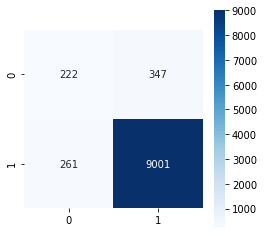

In [1025]:
plt.figure(figsize=(4,4)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

Интересно, но стратифицированное разбиение по категориальным фичам в итоге показало худщий результат.  
Модель переобучилась на класс 1? См. отчеты ниже.

In [982]:
#Best reports:

##Best macro_avg_train (Simple):

#Accuracy                             0.793417
#Macro_avg_test                           0.69
#Macro_avg_train                          0.88
#Size                                        1
#Formula                                Simple
#Method                           median_train
#Scaler                                   None
#Search.best_params_    {n_neighbors: 4, p: 2}

#              precision    recall  f1-score   support
#
#           0       0.46      0.39      0.42       569
#           1       0.96      0.97      0.97      9262
#
#    accuracy                           0.94      9831
#   macro avg       0.71      0.68      0.69      9831
#weighted avg       0.93      0.94      0.94      9831
#
#0 [[ 222  347]
#1 [ 261 9001]]
#     0    1

#----------------------------------------
##Best macro_avg_test (Simple):

#Accuracy                             0.708462
#Macro_avg_test                           0.71
#Macro_avg_train                          0.83
#Size                                      0.4
#Formula                                Simple
#Method                                   zero
#Scaler                         StandardScaler
#Search.best_params_    {n_neighbors: 4, p: 1}

#              precision    recall  f1-score   support

#           0       0.48      0.42      0.45       569
#           1       0.96      0.97      0.97      9262

#    accuracy                           0.94      9831
#   macro avg       0.72      0.69      0.71      9831
#weighted avg       0.94      0.94      0.94      9831
#
#0 [[ 237  332]
#1  [ 252 9010]]
#      0    1

#----------------------------------------
##Best macro_avg_train/test (Stratified):

#Accuracy                             0.504145
#Macro_avg_test                           0.51
#Macro_avg_train                          0.61
#Size                                      0.6
#Formula                            Stratified
#Method                           median_train
#Scaler                           RobustScaler
#Search.best_params_    {n_neighbors: 4, p: 2}

#              precision    recall  f1-score   support
#
#           0       0.12      0.04      0.06       569
#           1       0.94      0.98      0.96      9262
#
#    accuracy                           0.93      9831
#   macro avg       0.53      0.51      0.51      9831
#weighted avg       0.90      0.93      0.91      9831
#
#0 [[  23  546]
#1 [ 174 9088]]
#     0    1



# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [31]:
df_combo = df.copy()
df_combo.isnull().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [32]:
def generate_pair_features(df, y_name, separator = '#'):

    columns_df = list(df.columns)
    columns_df.remove(y_name)

    for col_name in columns_df:

        columns_pair = columns_df[:] 
        columns_pair.remove(col_name)
    
        for col_pair_name in columns_pair:
            
            new_col_name = col_name+separator+col_pair_name
            new_col_name_revers = col_pair_name+separator+col_name
            if new_col_name_revers in list(df.columns): #Если столбец с обратной парой уже существует, то пропускаем
                continue
            else:
                df[new_col_name] = df.apply((lambda x: '{}{}{}'.format(x[col_name],separator,x[col_pair_name])), axis=1)
    
    return df

In [33]:
%%time
df_combo = generate_pair_features(df_combo, 'ACTION')

CPU times: user 1min 4s, sys: 274 ms, total: 1min 4s
Wall time: 1min 4s


In [34]:
df_combo.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,...,ROLE_DEPTNAME#ROLE_TITLE,ROLE_DEPTNAME#ROLE_FAMILY_DESC,ROLE_DEPTNAME#ROLE_FAMILY,ROLE_DEPTNAME#ROLE_CODE,ROLE_TITLE#ROLE_FAMILY_DESC,ROLE_TITLE#ROLE_FAMILY,ROLE_TITLE#ROLE_CODE,ROLE_FAMILY_DESC#ROLE_FAMILY,ROLE_FAMILY_DESC#ROLE_CODE,ROLE_FAMILY#ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908,...,123472#117905,123472#117906,123472#290919,123472#117908,117905#117906,117905#290919,117905#117908,117906#290919,117906#117908,290919#117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539,...,123125#118536,123125#118536,123125#308574,123125#118539,118536#118536,118536#308574,118536#118539,118536#308574,118536#118539,308574#118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880,...,117884#117879,117884#267952,117884#19721,117884#117880,117879#267952,117879#19721,117879#117880,267952#19721,267952#117880,19721#117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322,...,119993#118321,119993#240983,119993#290919,119993#118322,118321#240983,118321#290919,118321#118322,240983#290919,240983#118322,290919#118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325,...,119569#119323,119569#123932,119569#19793,119569#119325,119323#123932,119323#19793,119323#119325,123932#19793,123932#119325,19793#119325


In [1034]:
df_combo.columns

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE', 'RESOURCE#MGR_ID', 'RESOURCE#ROLE_ROLLUP_1',
       'RESOURCE#ROLE_ROLLUP_2', 'RESOURCE#ROLE_DEPTNAME',
       'RESOURCE#ROLE_TITLE', 'RESOURCE#ROLE_FAMILY_DESC',
       'RESOURCE#ROLE_FAMILY', 'RESOURCE#ROLE_CODE', 'MGR_ID#ROLE_ROLLUP_1',
       'MGR_ID#ROLE_ROLLUP_2', 'MGR_ID#ROLE_DEPTNAME', 'MGR_ID#ROLE_TITLE',
       'MGR_ID#ROLE_FAMILY_DESC', 'MGR_ID#ROLE_FAMILY', 'MGR_ID#ROLE_CODE',
       'ROLE_ROLLUP_1#ROLE_ROLLUP_2', 'ROLE_ROLLUP_1#ROLE_DEPTNAME',
       'ROLE_ROLLUP_1#ROLE_TITLE', 'ROLE_ROLLUP_1#ROLE_FAMILY_DESC',
       'ROLE_ROLLUP_1#ROLE_FAMILY', 'ROLE_ROLLUP_1#ROLE_CODE',
       'ROLE_ROLLUP_2#ROLE_DEPTNAME', 'ROLE_ROLLUP_2#ROLE_TITLE',
       'ROLE_ROLLUP_2#ROLE_FAMILY_DESC', 'ROLE_ROLLUP_2#ROLE_FAMILY',
       'ROLE_ROLLUP_2#ROLE_CODE', 'ROLE_DEPTNAME#ROLE_TITLE',
       'ROLE_DEPTNAME#ROLE_FAMILY_DESC', 'R

In [35]:
%%time
X_train_orig_s_c,X_test_orig_s_c,y_train_orig_s_c,y_test_orig_s_c,strat_index_combo  = CountAndSuccMainSimple(df_combo.copy(), 0.8, method=1)
#Wall time: 21min 48s

/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/denis/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


CPU times: user 21min 48s, sys: 2.97 s, total: 21min 51s
Wall time: 21min 47s


In [830]:
#Стратифицированное разбиение с таким количеством столбцов и с таким объемом данных уже не сработало
#ValueError: The test_size = 1477 should be greater or equal to the number of classes = 2255
#X_train_orig_c,X_test_orig_c,y_train_orig_c,y_test_orig_c,strat_index_combo = CountAndSuccMainStratified(df_combo.copy(), 0.7, method=1)

In [36]:
X_train_orig_s_c.columns

Index(['MGR_ID#ROLE_CODE_count', 'MGR_ID#ROLE_CODE_flattened',
       'MGR_ID#ROLE_CODE_successes', 'MGR_ID#ROLE_DEPTNAME_count',
       'MGR_ID#ROLE_DEPTNAME_flattened', 'MGR_ID#ROLE_DEPTNAME_successes',
       'MGR_ID#ROLE_FAMILY_DESC_count', 'MGR_ID#ROLE_FAMILY_DESC_flattened',
       'MGR_ID#ROLE_FAMILY_DESC_successes', 'MGR_ID#ROLE_FAMILY_count',
       ...
       'ROLE_TITLE#ROLE_CODE_successes', 'ROLE_TITLE#ROLE_FAMILY_DESC_count',
       'ROLE_TITLE#ROLE_FAMILY_DESC_flattened',
       'ROLE_TITLE#ROLE_FAMILY_DESC_successes', 'ROLE_TITLE#ROLE_FAMILY_count',
       'ROLE_TITLE#ROLE_FAMILY_flattened', 'ROLE_TITLE#ROLE_FAMILY_successes',
       'ROLE_TITLE_count', 'ROLE_TITLE_flattened', 'ROLE_TITLE_successes'],
      dtype='object', length=135)

In [37]:
print('X_train_orig_s_c, shape: {}, null:{}'.format(X_train_orig_s_c.shape, X_train_orig_s_c.isnull().sum().sum()))
print('X_test_orig_s_c, shape: {}, null:{}'.format(X_test_orig_s_c.shape, X_test_orig_s_c.isnull().sum().sum()))

X_train_orig_s_c, shape: (22938, 135), null:74637
X_test_orig_s_c, shape: (9831, 135), null:161463


Перебрал только с одним size = 0.8

In [60]:
pipe_best_counters(size=0.8,formula='Simple',reports_df=reports_df,Xtr=X_train_orig_s_c,Xtst=X_test_orig_s_c,ytr=y_train_orig_s_c,ytst=y_test_orig_s_c,methods=methods,scalers=scalers)

KeyboardInterrupt: 

In [55]:
X_train, X_test = fillna(X_train_orig_s_c, X_test_orig_s_c,'zero')
X_train, X_test = scale(X_train, X_test,'StandartScaler')
y_test = y_test_orig_s_c
y_train = y_train_orig_s_c

In [56]:
#params = {
#    "n_neighbors": np.arange(2, 10, 2), 
#    "p": [1,4]
#}
#
#search = GridSearchCV(KNeighborsClassifier(), params, n_jobs=2, 
#                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), verbose=2)
#%time search.fit(pd.concat([X_train,X_test]), pd.concat([y_train,y_test]))

In [57]:
clf = KNeighborsClassifier(n_neighbors=4, p=1)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=1,
                     weights='uniform')

In [58]:
%%time
y_pred = clf.predict(X_test).astype('int')

CPU times: user 4.8 s, sys: 0 ns, total: 4.8 s
Wall time: 4.8 s


- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!

In [59]:
#отчет классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.44      0.46       569
           1       0.97      0.97      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.72      0.71      0.71      9831
weighted avg       0.94      0.94      0.94      9831



In [848]:
#отчет классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.46      0.49       569
           1       0.97      0.97      0.97      9262

    accuracy                           0.94      9831
   macro avg       0.74      0.72      0.73      9831
weighted avg       0.94      0.94      0.94      9831



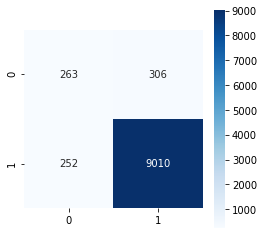

In [849]:
plt.figure(figsize=(4,4)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')